# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
warnings.warn('PerformanceWarning')

In [3]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Fetch current BTC price
btc_response = requests.get(btc_url).json()

# Fetch current ETH price
eth_response = requests.get(eth_url).json()

# Compute current value of my crpto
my_btc_value = btc_response['data']['1']['quotes']['USD']['price']
my_eth_value = eth_response['data']['1027']['quotes']['USD']['price']

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $28871.00
The current value of your 5.3 ETH is $1830.95


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [9]:
# Format current date as ISO format
current_start_date = pd.Timestamp("2023-07-28", tz="America/New_York").isoformat()
current_end_date = pd.Timestamp("2023-07-29", tz="America/New_York").isoformat()

# Set the tickers
tickers = ['AGG', 'SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
closing_price_data = api.get_bars(
    tickers,
    timeframe,
    start=current_start_date,
    end=current_end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = closing_price_data[closing_price_data["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = closing_price_data[closing_price_data["symbol"]=="SPY"].drop("symbol", axis=1)

#Concatenate dataframes
df_ticker = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])

In [10]:
# Pick AGG and SPY close prices
agg_close_price = float(df_ticker["AGG"]["close"][0])
spy_close_price = float(df_ticker["SPY"]["close"][0])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $97.56
Current SPY closing price: $456.92


In [11]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22846.00
The current value of your 200 AGG shares is $19512.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_value = my_btc_value + my_eth_value
stock_value = my_agg_value + my_spy_value

# Create savings DataFrame
df_savings = pd.DataFrame([crypto_value, stock_value], index=["Crypto", "Shares"], columns=["Amount"])

# Display savings DataFrame
display(df_savings)

,Amount
Crypto,30701.95
Shares,42358.00


<Axes: title={'center': 'Investment Portfolio'}, ylabel='Amount'>

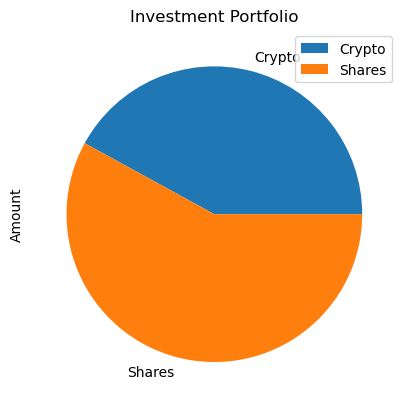

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y="Amount", title="Investment Portfolio")

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto_value + stock_value

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif total_savings == emergency_fund:
    print("Congratulations! You have reached your financial goal.")
elif total_savings < emergency_fund:
    print(f"You are ${emergency_fund - total_savings} away from reaching your financial goal.")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-07-28', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-07-28', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_stock_data

# Reorganize the DataFrame
# Separate ticker data
AGG_historical = df_stock_data[df_stock_data["symbol"]=="AGG"].drop("symbol", axis = 1)
SPY_historical = df_stock_data[df_stock_data["symbol"]=="SPY"].drop("symbol", axis = 1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG_historical, SPY_historical], axis=1, keys=["AGG","SPY"])

# Display sample data
df_stock_data

AGG                                      \
                             open     high       low   close   volume   
timestamp                                                               
2017-07-28 04:00:00+00:00  109.54  109.700  109.4900  109.70  1894332   
2017-07-31 04:00:00+00:00  109.69  109.725  109.5800  109.65  2362989   
2017-08-01 04:00:00+00:00  109.38  109.720  109.3600  109.72  2338876   
2017-08-02 04:00:00+00:00  109.71  109.770  109.6400  109.65  2253372   
2017-08-03 04:00:00+00:00  109.77  109.940  109.7400  109.86  1485193   
...                           ...      ...       ...     ...      ...   
2023-07-24 04:00:00+00:00   98.10   98.155   97.7900   97.81  6656782   
2023-07-25 04:00:00+00:00   97.58   97.790   97.5700   97.70  5794835   
2023-07-26 04:00:00+00:00   97.93   98.065   97.6800   98.02  5907380   
2023-07-27 04:00:00+00:00   97.84   97.930   97.1050   97.18  6937871   
2023-07-28 04:00:00+00:00   97.39   97.590   97.3102   97.56  7667973   

                                                      SPY                     \
                          trade_count        vwap    open     high       low   
timestamp                                                                      
2017-07-28 04:00:00+00:00        8841  109.624742  246.65  247.060  246.1300   
2017-07-31 04:00:00+00:00       10041  109.667698  247.37  247.480  246.5300   
2017-08-01 04:00:00+00:00       10476  109.649411  247.46  247.500  246.7160   
2017-08-02 04:00:00+00:00        8484  109.700965  247.47  247.600  246.3700   
2017-08-03 04:00:00+00:00        8740  109.830663  247.31  247.340  246.6400   
...                               ...         ...     ...      ...       ...   
2023-07-24 04:00:00+00:00       22651   97.916853  453.37  455.040  452.2980   
2023-07-25 04:00:00+00:00       20610   97.691545  453.92  456.735  453.8700   
2023-07-26 04:00:00+00:00       26939   97.864847  454.47  456.990  453.3800   
2023-07-27 04:00:00+00:00       32050   97.400513  459.02  459.440  451.5500   
2023-07-28 04:00:00+00:00       27237   97.508638  455.88  457.780  452.4918   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2017-07-28 04:00:00+00:00  246.89  50088359      168056  246.714676  
2017-07-31 04:00:00+00:00  246.79  65838659      164615  246.885069  
2017-08-01 04:00:00+00:00  247.30  55050401      151132  247.199252  
2017-08-02 04:00:00+00:00  247.42  47211216      178076  247.109454  
2017-08-03 04:00:00+00:00  246.98  40855997      143604  247.075390  
...                           ...       ...         ...         ...  
2023-07-24 04:00:00+00:00  454.20  54037303      401289  453.923213  
2023-07-25 04:00:00+00:00  455.44  55218342      383876  455.397175  
2023-07-26 04:00:00+00:00  455.51  71066805      528134  454.998694  
2023-07-27 04:00:00+00:00  452.49  92194375      627051  455.321716  
2023-07-28 04:00:00+00:00  456.92  79583623      525115  456.262095  

[1510 rows x 14 columns]

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4, 0.6],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [18]:
# Printing the simulation input data
MC_even_dist.portfolio_data

AGG                                      \
                             open     high       low   close   volume   
timestamp                                                               
2017-07-28 04:00:00+00:00  109.54  109.700  109.4900  109.70  1894332   
2017-07-31 04:00:00+00:00  109.69  109.725  109.5800  109.65  2362989   
2017-08-01 04:00:00+00:00  109.38  109.720  109.3600  109.72  2338876   
2017-08-02 04:00:00+00:00  109.71  109.770  109.6400  109.65  2253372   
2017-08-03 04:00:00+00:00  109.77  109.940  109.7400  109.86  1485193   
...                           ...      ...       ...     ...      ...   
2023-07-24 04:00:00+00:00   98.10   98.155   97.7900   97.81  6656782   
2023-07-25 04:00:00+00:00   97.58   97.790   97.5700   97.70  5794835   
2023-07-26 04:00:00+00:00   97.93   98.065   97.6800   98.02  5907380   
2023-07-27 04:00:00+00:00   97.84   97.930   97.1050   97.18  6937871   
2023-07-28 04:00:00+00:00   97.39   97.590   97.3102   97.56  7667973   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-07-28 04:00:00+00:00        8841  109.624742          NaN  246.65   
2017-07-31 04:00:00+00:00       10041  109.667698    -0.000456  247.37   
2017-08-01 04:00:00+00:00       10476  109.649411     0.000638  247.46   
2017-08-02 04:00:00+00:00        8484  109.700965    -0.000638  247.47   
2017-08-03 04:00:00+00:00        8740  109.830663     0.001915  247.31   
...                               ...         ...          ...     ...   
2023-07-24 04:00:00+00:00       22651   97.916853    -0.001837  453.37   
2023-07-25 04:00:00+00:00       20610   97.691545    -0.001125  453.92   
2023-07-26 04:00:00+00:00       26939   97.864847     0.003275  454.47   
2023-07-27 04:00:00+00:00       32050   97.400513    -0.008570  459.02   
2023-07-28 04:00:00+00:00       27237   97.508638     0.003910  455.88   

                                                                            \
                              high       low   close    volume trade_count   
timestamp                                                                    
2017-07-28 04:00:00+00:00  247.060  246.1300  246.89  50088359      168056   
2017-07-31 04:00:00+00:00  247.480  246.5300  246.79  65838659      164615   
2017-08-01 04:00:00+00:00  247.500  246.7160  247.30  55050401      151132   
2017-08-02 04:00:00+00:00  247.600  246.3700  247.42  47211216      178076   
2017-08-03 04:00:00+00:00  247.340  246.6400  246.98  40855997      143604   
...                            ...       ...     ...       ...         ...   
2023-07-24 04:00:00+00:00  455.040  452.2980  454.20  54037303      401289   
2023-07-25 04:00:00+00:00  456.735  453.8700  455.44  55218342      383876   
2023-07-26 04:00:00+00:00  456.990  453.3800  455.51  71066805      528134   
2023-07-27 04:00:00+00:00  459.440  451.5500  452.49  92194375      627051   
2023-07-28 04:00:00+00:00  457.780  452.4918  456.92  79583623      525115   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-07-28 04:00:00+00:00  246.714676          NaN  
2017-07-31 04:00:00+00:00  246.885069    -0.000405  
2017-08-01 04:00:00+00:00  247.199252     0.002067  
2017-08-02 04:00:00+00:00  247.109454     0.000485  
2017-08-03 04:00:00+00:00  247.075390    -0.001778  
...                               ...          ...  
2023-07-24 04:00:00+00:00  453.923213     0.004467  
2023-07-25 04:00:00+00:00  455.397175     0.002730  
2023-07-26 04:00:00+00:00  454.998694     0.000154  
2023-07-27 04:00:00+00:00  455.321716    -0.006630  
2023-07-28 04:00:00+00:00  456.262095     0.009790  

[1510 rows x 16 columns]

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011273,0.998258,0.994287,0.985365,0.989523,1.009451,1.002741,0.986639,0.996711,0.999969,...,1.000468,0.994542,1.003352,1.016504,0.984749,1.006089,0.995648,0.981153,1.002948,0.999156
2,0.998063,1.012370,1.000374,0.984920,0.994034,1.011381,0.994222,0.983561,0.998174,1.004226,...,1.010574,0.994264,1.001744,1.010542,0.992543,1.005157,0.998244,0.988309,1.005275,1.009835
3,0.998219,1.008899,1.005342,0.992045,0.997303,0.999908,0.991739,0.991352,0.990191,1.008970,...,1.008120,0.989270,1.006809,1.007037,0.987615,0.997629,0.999476,0.981742,0.991219,1.011342
4,0.989137,1.007759,1.006547,0.990420,1.000701,1.006572,0.994821,0.994719,1.000698,0.994209,...,1.008236,0.987471,1.010997,1.010394,0.988440,0.978136,0.992526,0.970319,0.986075,1.000976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.577504,2.256943,15.637308,11.365347,2.807619,4.182735,6.766100,7.605239,2.841956,3.518302,...,7.469870,8.082928,1.328330,5.672116,3.561065,7.852473,14.153792,15.563753,1.625171,6.293038
7557,5.615470,2.246310,15.589376,11.308253,2.778633,4.173044,6.683023,7.610846,2.863443,3.488511,...,7.476638,8.061251,1.337365,5.707833,3.567049,7.911352,14.039923,15.362113,1.613712,6.291910
7558,5.625328,2.264321,15.587171,11.186800,2.779544,4.186122,6.695537,7.610198,2.899041,3.477600,...,7.573641,8.013341,1.336980,5.676336,3.591630,8.034319,13.986285,15.319352,1.620286,6.308406
7559,5.633632,2.259123,15.520717,11.303670,2.770588,4.154991,6.675415,7.610047,2.891902,3.445532,...,7.486789,8.055429,1.340021,5.548304,3.613209,7.977186,14.120294,15.480921,1.629415,6.249872


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

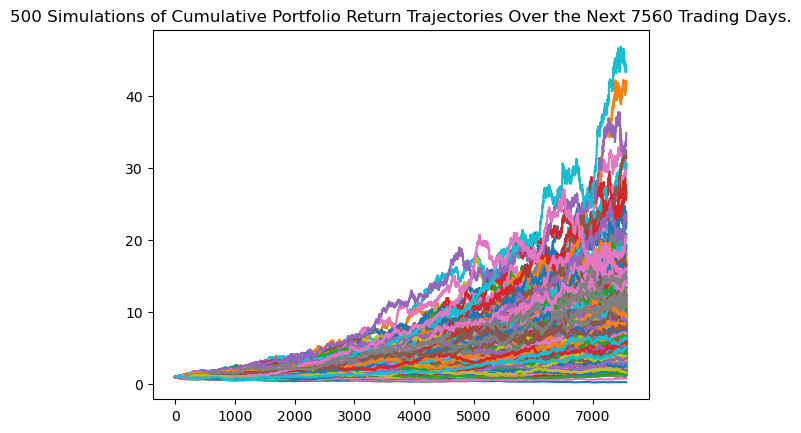

In [20]:
# Plot simulation outcomes
MC_even_dist.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

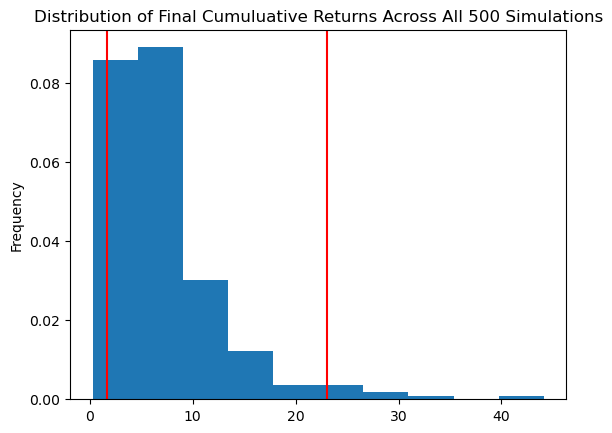

In [21]:
# Plot probability distribution and confidence intervals
MC_even_dist.plot_distribution()

### Retirement Analysis

In [24]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_summary = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
MC_summary

AttributeError: 'Series' object has no attribute 'series'

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [25]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_summary[8]*initial_investment,2)
ci_upper = round(MC_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

NameError: name 'mc_summary' is not defined

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(mc_summary[8]*initial_investment,2)
ci_upper = round(mc_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [32]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist_five = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.1, 0.9],
    num_simulation = 50,
    num_trading_days = 252*5
)

In [33]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011258,1.010748,0.994680,1.004858,1.001629,1.000765,1.013817,0.990885,0.990255,0.975649,...,1.001175,0.998683,0.988671,1.010930,0.984155,1.011611,0.998313,0.990354,0.995088,1.010003
2,1.024281,1.007806,0.984537,1.012785,1.008635,0.990458,1.010276,0.982391,0.984825,0.991129,...,0.980071,0.993883,1.006399,1.022363,0.998987,1.008768,0.971774,0.975720,1.002188,1.020358
3,1.037645,0.996682,0.974765,1.013903,1.005610,0.994175,1.019792,0.996028,0.996535,0.994090,...,0.981032,1.000595,1.011858,1.024690,0.986252,0.998794,0.956189,0.999200,1.003520,1.030879
4,1.033122,0.988192,0.961360,1.008449,0.996345,1.005839,1.021537,1.006081,1.003601,0.988369,...,0.981726,0.994908,1.000015,1.034138,1.005293,0.977788,0.969738,1.001449,1.011744,1.046488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.283863,0.787700,2.223707,1.907140,1.287119,1.919448,1.932467,2.520074,1.220953,2.420132,...,2.134025,1.261070,3.081806,2.830702,1.900310,1.666422,0.819060,1.201998,2.288159,1.374050
1257,1.276395,0.781186,2.225192,1.863555,1.284339,1.914621,1.947689,2.505403,1.229544,2.427369,...,2.173865,1.275884,3.117746,2.810854,1.902726,1.664302,0.823432,1.206121,2.324889,1.390852
1258,1.270363,0.772466,2.248983,1.903195,1.274050,1.885589,1.916454,2.444480,1.234775,2.407635,...,2.167452,1.283330,3.114255,2.820343,1.901813,1.653636,0.837507,1.231795,2.291092,1.374702
1259,1.286177,0.759084,2.242612,1.888382,1.266283,1.925471,1.917563,2.471397,1.220442,2.427660,...,2.169492,1.282892,3.106951,2.800891,1.906675,1.650919,0.833951,1.252174,2.273182,1.390708


<Axes: title={'center': '50 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

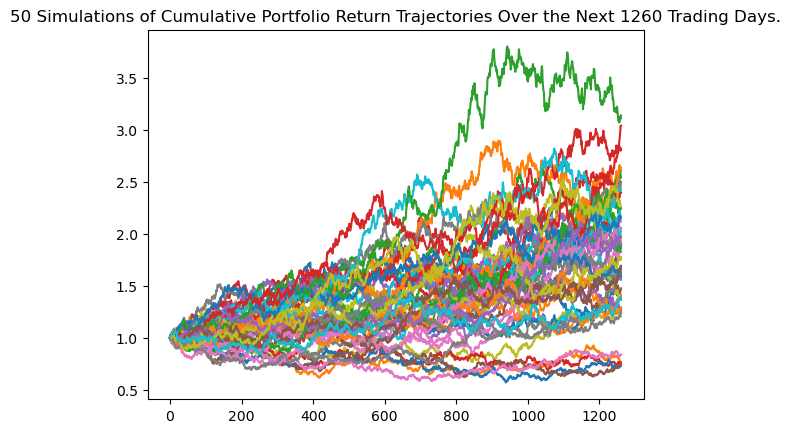

In [34]:
# Plot simulation outcomes
MC_even_dist_five.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 50 Simulations'}, ylabel='Frequency'>

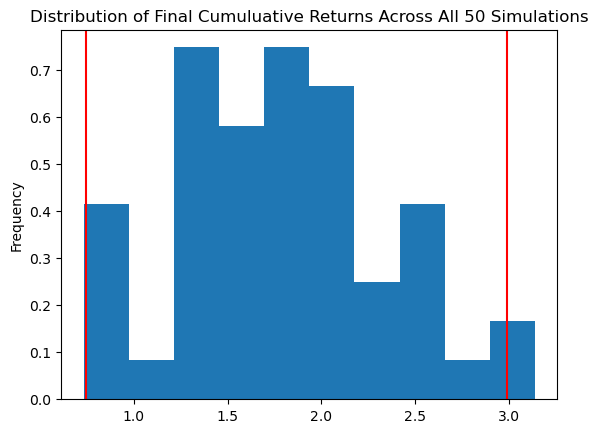

In [35]:
# Plot probability distribution and confidence intervals
MC_even_dist_five.plot_distribution()

In [36]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_summary_five = MC_even_dist_five.summarize_cumulative_return()

# Print summary statistics
MC_summary_five

AttributeError: 'Series' object has no attribute 'series'

In [ ]:
# Set initial investment
initial_investment_five = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(MC_summary_five[8]*initial_investment_five,2)
ci_upper_five = round(MC_summary_five[9]*initial_investment_five,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_five} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

### Ten Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist_ten = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.2, 0.8],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [26]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.022604,1.014239,0.982695,0.996528,1.001603,0.986091,0.985082,0.990264,0.996205,0.984940,...,1.009857,0.993842,1.004139,1.004262,1.005071,1.013818,0.995853,0.995964,0.994029,1.008099
2,1.031199,1.028248,0.990380,1.008856,0.993928,0.998937,0.974611,0.993624,0.996521,0.991969,...,1.017073,0.995682,1.012164,0.991673,0.980469,1.019284,0.996412,0.994701,1.007940,1.006219
3,1.024784,1.033258,0.998909,1.017284,0.999260,0.991384,0.982893,0.995077,0.991984,0.980477,...,1.028766,0.997889,1.000478,0.988627,0.975859,1.027487,0.999788,1.010937,0.994247,1.013388
4,1.034114,1.024726,0.982669,1.018384,1.000945,0.993028,0.985749,1.001047,1.015378,0.969482,...,1.024943,0.983571,0.991057,0.988336,0.999799,1.024637,1.000086,1.004081,0.986493,1.019505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.355583,3.219688,2.931815,1.493415,2.446017,2.027231,6.259794,2.053315,1.078641,1.215682,...,1.591263,1.549841,3.013622,1.505295,1.401756,1.268717,1.221111,1.949310,3.554074,4.006042
2517,4.400757,3.216578,2.981683,1.507477,2.420442,2.029055,6.176235,2.048443,1.066047,1.211219,...,1.586556,1.558993,3.038888,1.501012,1.433801,1.271191,1.243699,1.938789,3.556402,4.081048
2518,4.457777,3.239256,2.966023,1.523743,2.423017,2.024024,6.055839,2.018136,1.046097,1.222235,...,1.583171,1.566402,3.015787,1.512218,1.435453,1.272720,1.249160,1.934510,3.634776,4.046659
2519,4.413772,3.229123,2.978399,1.526078,2.451807,2.045725,6.005275,2.025635,1.046405,1.223345,...,1.577858,1.594255,3.009559,1.496828,1.423960,1.277697,1.234596,1.919079,3.687057,4.077155


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

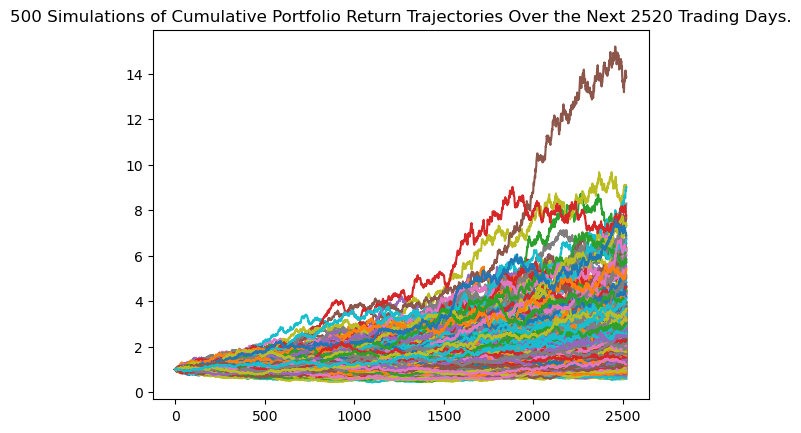

In [30]:
# Plot simulation outcomes
MC_even_dist_ten.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

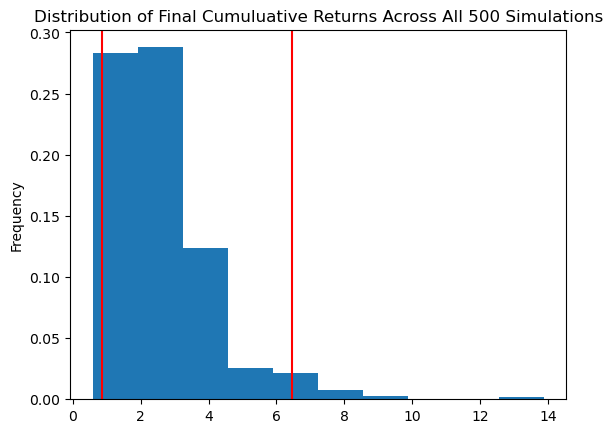

In [31]:
# Plot probability distribution and confidence intervals
MC_even_dist_ten.plot_distribution()

In [33]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_summary_ten = MC_even_dist_ten.summarize_cumulative_return()

# Print summary statistics
print(MC_summary_ten)

AttributeError: 'Series' object has no attribute 'series'

In [ ]:
# Set initial investment
initial_investment_ten = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(MC_summary_ten[8]*initial_investment_ten,2)
ci_upper_ten = round(MC_summary_ten[9]*initial_investment_ten,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_ten} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")